# Pair Programming Regresion Lineal - Random Forest

In [1]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Barra de progreso de un proceso
# ------------------------------------------------------------------------------
from tqdm import tqdm

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

In [2]:
df = pd.read_csv('datos/pokePd_estandarizado.csv', index_col = 0)
df.head()

,Type,Total,HP,Attack,Defense,Sp.Atk,Sp.Def,Speed_BOX
0,Grass,-0.819945,-0.75000,-0.738095,-0.500000,-0.088889,-0.131579,16.160251
1,Poison,-0.819945,-0.75000,-0.738095,-0.500000,-0.088889,-0.131579,16.160251
2,Grass,-0.337950,-0.28125,-0.428571,-0.166667,0.244444,0.263158,19.724770
3,Poison,-0.337950,-0.28125,-0.428571,-0.166667,0.244444,0.263158,19.724770
4,Grass,0.326870,0.34375,0.047619,0.309524,0.688889,0.789474,24.005888


En el pair programming de hoy debéis usar el csv que guardastéis cuando hicistéis el pairprgramming de codificicación (este csv debería tener las variables estadandarizas).

En pairprogramming anteriores ajustastéis vuestro datos a una regresión lineal y a un Decision Tree. El objetivo de hoy es:

- Ajustar el modelo a un Random Forest
- Extraer las métricas
- Debatid entre vosotras que modelo es mejor y por qué (basándose en las métricas)

In [3]:
# al igual que en la regresión lineal tenemos que separar nuestro dataframe en X e y

X = df.drop(["Speed_BOX", 'Type'], axis = 1)
y = df["Speed_BOX"]

In [4]:
# y dividir nuestros datos en train y test para poder evaluar la bondad de nuestro modelo

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [5]:
# crear un diccionario con los hiperparámetros que queríamos probar

param = {"max_depth": [1,2,3], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [5,7,10],
        "min_samples_leaf": [5,7,10]} 

In [6]:
gs_rf = GridSearchCV(
    estimator=RandomForestRegressor(), # tipo de modelo que queremos hacer
    param_grid= param, # que hiperparámetros 
    cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro.
    verbose=-1, # para que no nos printee ningún mensaje en pantalla
    return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
    scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

In [7]:
gs_rf.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 2, 3], 'max_features': [1, 2, 3],
                         'min_samples_leaf': [5, 7, 10],
                         'min_samples_split': [5, 7, 10]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [8]:
#vemos cuál es mejor 
bosque = gs_rf.best_estimator_
bosque

RandomForestRegressor(max_depth=3, max_features=3, min_samples_leaf=10,
                      min_samples_split=7)

In [ ]:
# dibujemos los árboles de nuestro bosque

# for arbol in tqdm(bosque.estimators_):
#     fig = plt.figure(figsize=(40, 20))
#     tree.plot_tree(arbol, feature_names= x_train.columns, filled = True)
#     plt.show()

In [9]:
y_pred_test_rf = bosque.predict(x_test)
y_pred_train_rf = bosque.predict(x_train)

In [10]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                  'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                  'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                  'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                  "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [11]:
dt_results = metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "Random Forest")
dt_results

,MAE,MSE,RMSE,R2,set,modelo
0,4.300198,28.559796,5.344137,0.358629,test,Random Forest
1,3.857605,23.247194,4.821534,0.445773,train,Random Forest


In [12]:
df_comparacion = pd.read_csv('datos/comparacion_regresion_decision.csv', index_col = 0)
df_comparacion.head()

,MAE,MSE,RMSE,R2,set,modelo
0,1.899720e+00,1.484213e+01,3.852549e+00,0.666688,test,Decision tree I
1,6.113253e-17,1.891019e-31,4.348585e-16,1.000000,train,Decision tree I
0,4.599458e-01,4.094236e-01,6.398622e-01,0.990806,test,Linear Regresion
1,4.689115e-01,4.536421e-01,6.735296e-01,0.989185,train,LinearRegression


In [13]:
df_resultado_final = pd.concat([dt_results, df_comparacion], axis = 0)
df_resultado_final.head(6)

,MAE,MSE,RMSE,R2,set,modelo
0,4.300198e+00,2.855980e+01,5.344137e+00,0.358629,test,Random Forest
1,3.857605e+00,2.324719e+01,4.821534e+00,0.445773,train,Random Forest
0,1.899720e+00,1.484213e+01,3.852549e+00,0.666688,test,Decision tree I
1,6.113253e-17,1.891019e-31,4.348585e-16,1.000000,train,Decision tree I
0,4.599458e-01,4.094236e-01,6.398622e-01,0.990806,test,Linear Regresion
1,4.689115e-01,4.536421e-01,6.735296e-01,0.989185,train,LinearRegression


#### COMENTARIO


- En este caso los valores del random forest no son  buenos, el R2 es bajo y el RMSE es alto, lo que podría ser overfitting
- En el decision tree podemos observar que hay claro overfitting, ya que la diferencia entre el R2 en el test y el train es mayor de 0.1.
- Los valores obtenidos en la regresión lineal parecen los que representan un mejor modelo de predicción ya que hay una diferencia muy poco significativa entre el R2 del test y el train, siendo en ambos casos R2 bastante elevado. Por tanto, teniendo en cuenta que se cumplen todas las asunciones para poder realizar una regresión lineal y que las métricas en este caso son las mejores, este sería el modelo que aplicaríamos en nuestras predicciones.

In [14]:
# vamos a crearnos un dataframe, igual que hicimos en la clase anterior con la importancia de cada una de las variables incluidas en el modelo
importancia_predictores = pd.DataFrame({'predictor': x_train.columns,
                                        'importancia': bosque.feature_importances_})

In [15]:
# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)
# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
0,Total,0.527413
4,Sp.Atk,0.187490
3,Defense,0.128744
1,HP,0.063104
2,Attack,0.062546
5,Sp.Def,0.030702


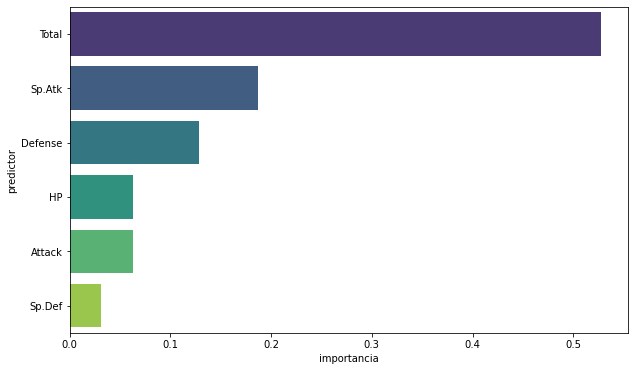

In [16]:
# por último, sacamos un gráfico con los resultados para verlo de una forma más amigable

plt.figure(figsize=(10,6)) 
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()